In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [14]:
class Net(nn.Module):

    def __init__(self,input,hidden,output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input,hidden)  
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,output)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
print(Net(1,2,3))

Net(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
)


In [11]:
class Memory:
    def __init__(self,size=1000):
        self.size = size
        self.memory = []
    
    def add_memories(self, mems):
        
        for mem in mems:
            self.memory.append(mem)
        for i in range(max(len(self.memory)-self.size, 0)):
            self.memory.pop(0)
            
    def add_memory(self, mem):
        self.add_memories([mem])       


    
    def get_memories(self,num_mems=100,upto=True):
        num_mems = min(len(self.memory),num_mems) if upto else num_mems
        if num_mems == 0 :
            return []
        mems = []
        mem_inds = []
        
        for i in range(num_mems):
            mem, mem_ind = self.get_prior_mem()
            mems.append(mem)
            mem_inds.append(mem_ind)
        return mems, mem_inds
    
    def get_mem(self):
        ind = int(np.random.random()*len(self.memory))
        return self.memory[ind][0], ind
    
    def get_prior_mem(self):
        #print('getting',self.memory)
        losses = [mem[1] for mem in self.memory]
        total = sum(losses)
        rand = np.random.random()
        running_total = 0
        for mem_ind in range(len(self.memory)):
            mem = self.memory[mem_ind]
            running_total += mem[1]/total
            if running_total > rand:
                return mem[0], mem_ind
            
    def update_loss(self,index,new_loss):
        #print(self.memory[index] )
        self.memory[index][1] = new_loss
        
    def update_losses(self,mem_inds,losses):
        for mem_ind, loss in zip(mem_inds,losses):
            self.update_loss(mem_ind,loss)
        
        
    

In [ ]:
import gym
from tqdm import tqdm
class RL_cartpole:
    def __init__(self, model_func, env, observation_size, experience_size = 500, gamma = 0.9, epsilon_min = 0.01, epsilon_max = 0.5):
         
        self.env = env
        self.memory = Memory(20000)
        self.gamma = 0.9
        self.epsilon_max = 0.5
        self.epsilon = self.epsilon_max
        self.epsilon_min = 0.01
        self.criterion = F.mse_loss
        self.observation_size = observation_size
        self.log = []
        self.experience_size = experience_size
        self.action_size = env.action_space.n
        self.model = model_func(self.observation_size,8,self.action_size)
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        
    def get_q_values(self,series):
        q_values = []
        discounted_reward = 0
        states = []
        for state, action, reward in series[::-1]:
            #print(str(state))
            if(not str(state) in states):
                discounted_reward *= self.gamma
                discounted_reward += reward
                q_values.append([state, action, discounted_reward])
                states.append(str(state))
        return q_values
    
    def choose_action(self, pred_vales):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(pred_vales.detach().numpy())
            
    def make_targets(self,action_values, preds):
        preds_arr = preds.detach().numpy()
        targets = []
        for time_step in range(len(action_values)):
            curr_target = []
            for i in range(self.action_size):
                if i != action_values[time_step][0]:
                    curr_target.append(preds_arr[time_step][i])
                else:
                    curr_target.append(action_values[time_step][1])
            targets.append(curr_target)
        return torch.tensor(targets).float()
        
    def run(self, epochs):
        self.log = []
        self.losses = []
        
        epsilon_discount = (self.epsilon_min/self.epsilon_max)**(1/epochs)
        for epoch in tqdm(range(epochs)):
            pobservation = self.env.reset()
            done = False
            current_memory = []
            total_reward = 0
            while not done:
               
                pred_values = self.model(torch.tensor(pobservation).float())
                action = self.choose_action(pred_values)
                observation, reward, done, info = self.env.step(action)
                current_memory.append([pobservation, action, reward])
                pobservation = observation
                total_reward += reward
                
            self.log.append(total_reward)
            q_values = self.get_q_values(current_memory)
            mems = []
            inds = []
            if len(self.memory.memory) > 0 and self.experience_size != 0:
                mems, inds = self.memory.get_memories(self.experience_size)
                q_values += mems
            #print(q_values)
            states = torch.tensor([exp[0] for exp in q_values]).float()

            action_values = [[exp[1], exp[2]] for exp in q_values]
            preds = self.model(states)
            target = self.make_targets(action_values, preds)
            
            output = self.model(states)
            self.optimizer.zero_grad()   # zero the gradient buffers
            loss = self.criterion(output, target)
            self.losses.append(loss.detach().numpy())
            loss.backward()
            self.optimizer.step()
            loss_ind = [sum(i) for i in (target.detach().numpy()-output.detach().numpy())**2]
            self.memory.add_memories([[q_values[i],loss_ind[i]] for i in range(len(current_memory))])
            exp_loss_ind = loss_ind[len(loss_ind)-self.experience_size:]
            self.memory.update_losses(inds, exp_loss_ind)
            
            self.epsilon *= epsilon_discount
        return self.log, self.losses
    
    def show(self):
        pobservation = self.env.reset()
        done = False
        current_memory = []
        total_reward = 0
        while not done:
            self.env.render()
            pred_values = self.model(torch.tensor(pobservation).float())
            action = self.choose_action(pred_values)
            observation, reward, done, info = self.env.step(action)
            current_memory.append([pobservation, action, reward])
            pobservation = observation
            total_reward += reward
        print(total_reward)
        
                
                
rl=RL_cartpole(Net,gym.make("CartPole-v1"),4,gamma=0.9,experience_size=1000)
log, losses = rl.run(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/trentjohnson/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 69%|██████▉   | 694/1000 [17:05<25:45,  5.05s/it]

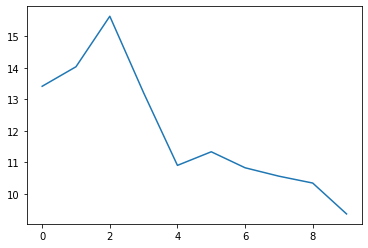

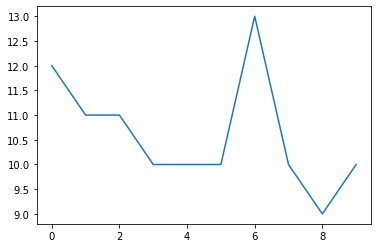

In [25]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses)
plt.show()

plt.plot(range(len(rl.log)),rl.log)
plt.show()

In [ ]:
import gym
from tqdm import tqdm
class RL_mountain:
    def __init__(self, model_func, env, observation_size, experience_size = 500, gamma = 0.9, epsilon_min = 0.01, epsilon_max = 0.5):
         
        self.env = env
        self.memory = Memory(20000)
        self.gamma = 0.9
        self.epsilon_max = 0.5
        self.epsilon = self.epsilon_max
        self.epsilon_min = 0.01
        self.criterion = F.mse_loss
        self.observation_size = observation_size
        self.log = []
        self.experience_size = experience_size
        self.action_size = env.action_space.n
        self.model = model_func(self.observation_size,8,self.action_size)
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        
    def get_q_values(self,series):
        q_values = []
        discounted_reward = 0
        states = []
        for state, action, reward in series[::-1]:
            print(state in states)
            if(not state in states):
                discounted_reward *= self.gamma
                discounted_reward += reward
                q_values.append([state, action, discounted_reward])
                states.append(state)
        return q_values
    
    def choose_action(self, pred_vales):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(pred_vales.detach().numpy())
            
    def make_targets(self,action_values, preds):
        preds_arr = preds.detach().numpy()
        targets = []
        for time_step in range(len(action_values)):
            curr_target = []
            for i in range(self.action_size):
                if i != action_values[time_step][0]:
                    curr_target.append(preds_arr[time_step][i])
                else:
                    curr_target.append(action_values[time_step][1])
            targets.append(curr_target)
        return torch.tensor(targets).float()
        
    def run(self, epochs):
        self.log = []
        self.losses = []
        
        epsilon_discount = (self.epsilon_min/self.epsilon_max)**(1/epochs)
        for epoch in tqdm(range(epochs)):
            pobservation = self.env.reset()
            done = False
            current_memory = []
            total_reward = 0
            while not done:
                pred_values = self.model(torch.tensor(pobservation).float())
                action = self.choose_action(pred_values)
                observation, reward, done, info = self.env.step(action)
                adj_reward = reward + observation[0]
                current_memory.append([pobservation, action, adj_reward])
                pobservation = observation
                total_reward += adj_reward
                
            self.log.append(total_reward)
            q_values = self.get_q_values(current_memory)
            mems = []
            inds = []
            if len(self.memory.memory) > 0 and self.experience_size != 0:
                mems, inds = self.memory.get_memories(self.experience_size)
                q_values += mems
            #print(q_values)
            states = torch.tensor([exp[0] for exp in q_values]).float()

            action_values = [[exp[1], exp[2]] for exp in q_values]
            preds = self.model(states)
            target = self.make_targets(action_values, preds)
            
            output = self.model(states)
            self.optimizer.zero_grad()   # zero the gradient buffers
            loss = self.criterion(output, target)
            self.losses.append(loss.detach().numpy())
            loss.backward()
            self.optimizer.step()
            loss_ind = [sum(i) for i in (target.detach().numpy()-output.detach().numpy())**2]
            self.memory.add_memories([[q_values[i],loss_ind[i]] for i in range(len(current_memory))])
            exp_loss_ind = loss_ind[len(loss_ind)-self.experience_size:]
            self.memory.update_losses(inds, exp_loss_ind)
            
            self.epsilon *= epsilon_discount
        return self.log, self.losses
    
    def show(self):
        pobservation = self.env.reset()
        done = False
        current_memory = []
        total_reward = 0
        while not done:
            self.env.render()
            pred_values = self.model(torch.tensor(pobservation).float())
            action = self.choose_action(pred_values)
            observation, reward, done, info = self.env.step(action)
            current_memory.append([pobservation, action, reward])
            pobservation = observation
            total_reward += reward
        print(total_reward)
        
                
                
rl=RL(Net,gym.make("CartPole-v1"),2,gamma=0.9,experience_size=1000)
log, losses = rl.run(10)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(rl.losses)),rl.losses)
plt.show()

plt.plot(range(len(rl.log)),rl.log)
plt.show()

In [ ]:
rl.show()

In [ ]:
loger = rl.log

In [ ]:
plt.plot(log[:600])
plt.plot(range(len(loger)),loger,"g")
plt.show()

In [ ]:
env = gym.make("MountainCar-v0")
env.observation_space

In [7]:
env = gym.make("MountainCar-v0")
env.action_space.n

3

In [8]:
set([env.action_space.sample() for i in range(100)])

{0, 1, 2}